In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.model_selection import train_test_split
from keras.layers import Embedding,LSTM,Dense,Dropout,Conv1D,MaxPooling1D,Bidirectional
from keras.initializers import Constant
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import warnings 
%matplotlib inline
warnings.filterwarnings('ignore')

In [195]:
df=pd.read_csv('combined_enron.csv')
df.head()

,label,label_num,text
0,ham,0,subject fw weather sites this is the list of w...
1,spam,1,subject i cant believe the changma wow wow wow...
2,spam,1,subject 4 color printing special request addit...
3,spam,1,subject nobody can beat us poloponybreakaway i...
4,ham,0,subject energy extravaganza 2 weeks away energ...


In [196]:
df['text'][0]

'subject fw weather sites this is the list of weather sites preston uses to report weather trends at the nng tw morning meeting tk original message from roobaert preston sent monday january 14 2002 8 19 am to lohman tk subject weather sites research group other sites http www weather com http www noaa gov http www cnn com weather '

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33702 entries, 0 to 33701
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      33702 non-null  object
 1   label_num  33702 non-null  int64 
 2   text       33702 non-null  object
dtypes: int64(1), object(2)
memory usage: 790.0+ KB


In [198]:
df.shape

(33702, 3)

In [199]:
df.drop(columns=['label'],axis=1,inplace=True)

In [200]:
df.head()

,label_num,text
0,0,subject fw weather sites this is the list of w...
1,1,subject i cant believe the changma wow wow wow...
2,1,subject 4 color printing special request addit...
3,1,subject nobody can beat us poloponybreakaway i...
4,0,subject energy extravaganza 2 weeks away energ...


In [201]:
df['label_num'].value_counts()

label_num
1    17157
0    16545
Name: count, dtype: int64

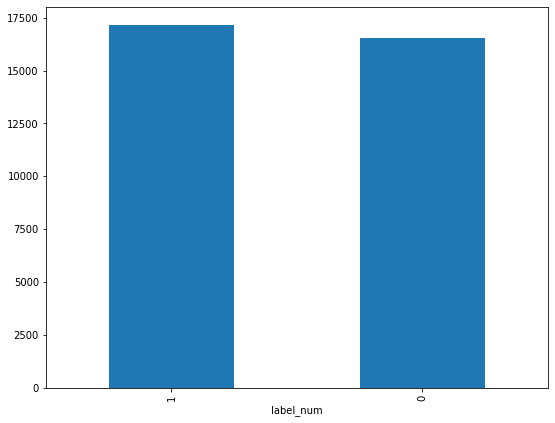

In [202]:
df['label_num'].value_counts().plot(kind='bar',figsize=(9,7))
plt.show()

In [203]:
sw=stopwords.words('english')

In [204]:
lemmatizer=WordNetLemmatizer()

In [205]:
def preprocessing(text):
    text=text.lower()
    text=re.sub('[^a-z]',' ',text)
    text=re.sub('\s+[a-z]\s+',' ',text)
    text=re.sub('\s+',' ',text)
    n_s_words=[word for word in text.split() if word not in sw]
    l_words=[lemmatizer.lemmatize(word) for word in n_s_words]
    return ' '.join(l_words)

In [206]:
df['text_pre']=df['text'].apply(preprocessing)

In [207]:
df.head()

,label_num,text,text_pre
0,0,subject fw weather sites this is the list of w...,subject fw weather site list weather site pres...
1,1,subject i cant believe the changma wow wow wow...,subject cant believe changma wow wow wow unbel...
2,1,subject 4 color printing special request addit...,subject color printing special request additio...
3,1,subject nobody can beat us poloponybreakaway i...,subject nobody beat u poloponybreakaway ionmel...
4,0,subject energy extravaganza 2 weeks away energ...,subject energy extravaganza week away energy e...


In [208]:
df.drop(columns=['text'],axis='columns',inplace=True)

In [209]:
df.head()

,label_num,text_pre
0,0,subject fw weather site list weather site pres...
1,1,subject cant believe changma wow wow wow unbel...
2,1,subject color printing special request additio...
3,1,subject nobody beat u poloponybreakaway ionmel...
4,0,subject energy extravaganza week away energy e...


In [210]:
df.sample(10)

,label_num,text_pre
20526,1,subject welcome online affair network go massi...
15144,0,subject aram visit jesus yalked aram calendar ...
25498,1,subject stock selector doctype html public c d...
4257,1,subject get laid tonight amatuer match r e adu...
29174,0,subject enymex arnold handling going forward g...
681,0,subject portland lease brief discussion marcus...
27488,0,subject friday brown bag option pricing hello ...
21284,0,subject ce deal clean need make change sitara ...
19253,0,subject nom vols thru agree eileen ponton davi...
8508,0,subject year end performance feedback note rec...


In [211]:
df['text_pre']=df['text_pre'].str.replace('subject','')

In [212]:
df.sample(10)

,label_num,text_pre
22107,1,high quality custom logo business identity ar...
21561,0,neon discussion november material upcoming we...
23959,1,lose pound day lose weight fast without speci...
20170,0,project doorstep responsibility matrix thanks...
2640,1,impress girl huge cumshot heya cum ever dribb...
2604,1,boletin difusion consejeros electorales cc me...
31397,0,cornshucker point gas nomintated september su...
32400,0,ee city attached spreadsheet indicating netco...
29837,0,eletrobolt louise wanted make sure aware curr...
2142,1,looking agent bathtub saling note eamil fit p...


In [213]:
df.head()

,label_num,text_pre
0,0,fw weather site list weather site preston us ...
1,1,cant believe changma wow wow wow unbeliebable...
2,1,color printing special request additional inf...
3,1,nobody beat u poloponybreakaway ionmelbourne ...
4,0,energy extravaganza week away energy extravag...


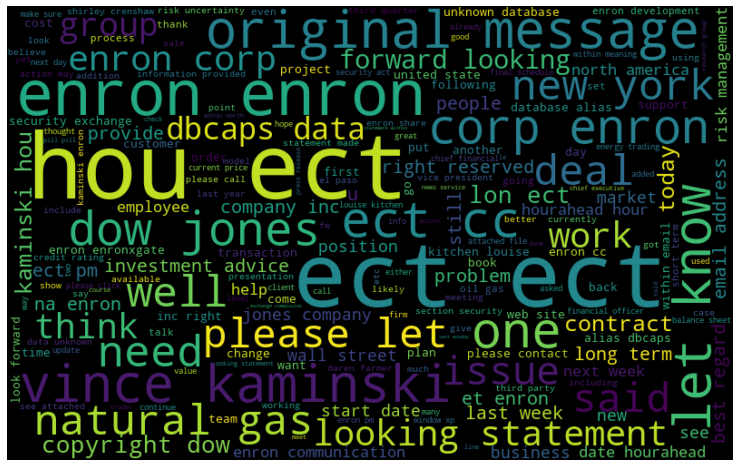

In [214]:
plt.figure(figsize=(13,9))
all_sen=' '.join([sentence for sentence in df['text_pre']])
wordcloud_all=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(all_sen)
plt.imshow(wordcloud_all,interpolation='bilinear')
plt.axis('off')
plt.show()

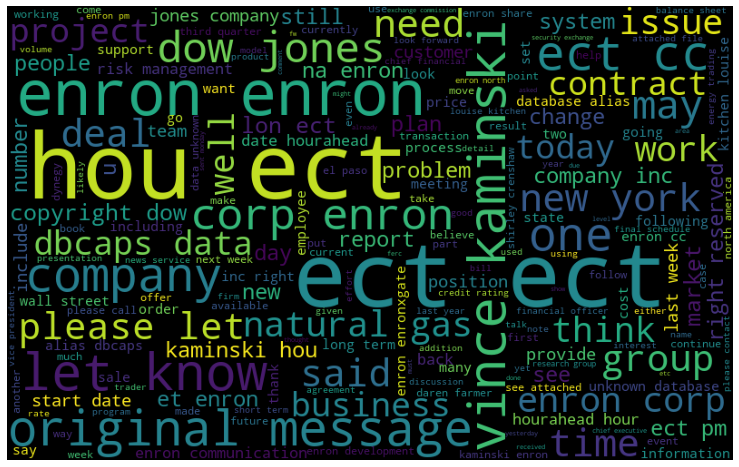

In [215]:
plt.figure(figsize=(13,9))
ham_sen=' '.join(df['text_pre'][df['label_num']==0].tolist())
wordcloud_ham=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(ham_sen)
plt.imshow(wordcloud_ham)
plt.axis('off')
plt.show()

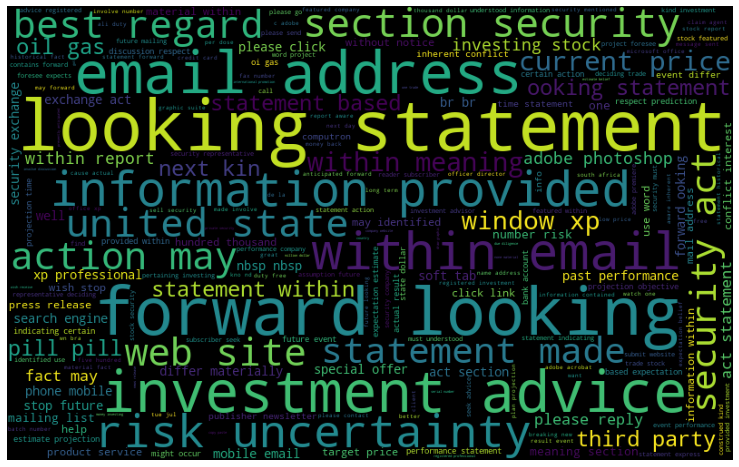

In [216]:
plt.figure(figsize=(13,9))
spam_sen=' '.join([sentence for sentence in df['text_pre'][df['label_num']==1]])
wordcloud_spam=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(spam_sen)
plt.imshow(wordcloud_spam)
plt.axis('off')
plt.show()

In [217]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['text_pre'])
seq=tokenizer.texts_to_sequences(df['text_pre'])

In [218]:
seq[0]

[310,
 862,
 101,
 84,
 862,
 101,
 10095,
 2110,
 35,
 862,
 2615,
 5529,
 979,
 399,
 88,
 4539,
 109,
 26,
 38067,
 10095,
 52,
 191,
 379,
 5489,
 4539,
 862,
 101,
 147,
 49,
 101,
 22,
 47,
 862,
 4,
 22,
 47,
 22056,
 2451,
 22,
 47,
 4344,
 4,
 862]

In [219]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

136398

In [220]:
pad_seq=pad_sequences(seq,maxlen=700,padding='post')

In [221]:
pad_seq[0]

array([  310,   862,   101,    84,   862,   101, 10095,  2110,    35,
         862,  2615,  5529,   979,   399,    88,  4539,   109,    26,
       38067, 10095,    52,   191,   379,  5489,  4539,   862,   101,
         147,    49,   101,    22,    47,   862,     4,    22,    47,
       22056,  2451,    22,    47,  4344,     4,   862,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [222]:
embedding_index={}
glove_file=open('glove.6B.100d.txt',encoding='utf-8')
for line in glove_file:
    record=line.split()
    word=record[0]
    emb=np.asarray(record[1:],dtype='float32')
    embedding_index[word]=emb
glove_file.close()

In [223]:
embedding_vectors=np.zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    vec=embedding_index.get(word)
    if vec is not None:
        embedding_vectors[index]=vec

In [224]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61352998,  0.031901  ,  0.50799   , ...,  0.26317999,
        -0.72104001,  0.066753  ],
       [ 0.16091999,  0.36704999, -0.074436  , ..., -0.19801   ,
        -0.047521  , -0.0025443 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55712998,  0.064607  , -0.29379001, ...,  0.093234  ,
        -0.1113    ,  0.26857001]])

In [225]:
X_train,X_test,y_train,y_test=train_test_split(pad_seq,df['label_num'],test_size=0.2,random_state=101,shuffle=True,
                                              stratify=df['label_num'])

In [226]:
X_train.shape

(26961, 700)

In [227]:
X_test.shape

(6741, 700)

In [228]:
y_train.value_counts()

label_num
1    13725
0    13236
Name: count, dtype: int64

In [229]:
y_test.value_counts()

label_num
1    3432
0    3309
Name: count, dtype: int64

In [253]:
model=Sequential([
    Embedding(vocab_size,100,embeddings_initializer=Constant(embedding_vectors),trainable=False),
    Conv1D(32,3,padding='same',activation='relu',input_shape=(700,)),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dense(1,activation='sigmoid')
])

In [254]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [255]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [256]:
early_stopping=EarlyStopping(monitor='val_loss',patience=2)

In [257]:
history=model.fit(X_train,y_train,epochs=100,validation_split=0.1,callbacks=early_stopping)

Epoch 1/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 254s 321ms/step - accuracy: 0.8939 - loss: 0.2456 - val_accuracy: 0.9826 - val_loss: 0.0509
Epoch 2/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 248s 326ms/step - accuracy: 0.9904 - loss: 0.0336 - val_accuracy: 0.9859 - val_loss: 0.0452
Epoch 3/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 247s 325ms/step - accuracy: 0.9956 - loss: 0.0151 - val_accuracy: 0.9870 - val_loss: 0.0416
Epoch 4/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 248s 327ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9878 - val_loss: 0.0458
Epoch 5/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 249s 328ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9881 - val_loss: 0.0397
Epoch 6/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 250s 329ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9878 - val_loss: 0.0537
Epoch 7/100
759/759 ━━━━━━━━━━━━━━━━━━━━ 251s 331ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9874 - val_loss: 0.0665


In [258]:
model.evaluate(X_test,y_test)

211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9866 - loss: 0.0643


[0.06454776227474213, 0.9866488575935364]

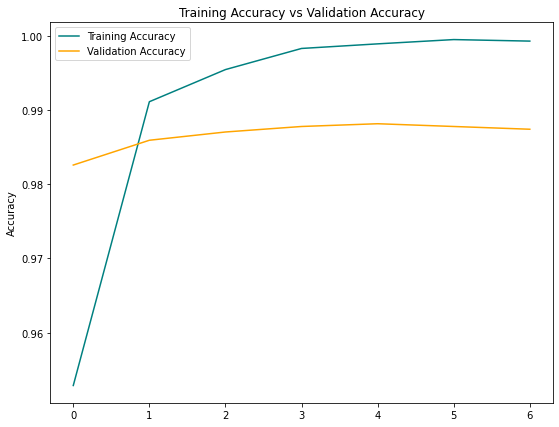

In [259]:
plt.figure(figsize=(9,7))
plt.plot(history.history['accuracy'],label='Training Accuracy',color='teal')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy',color='orange')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

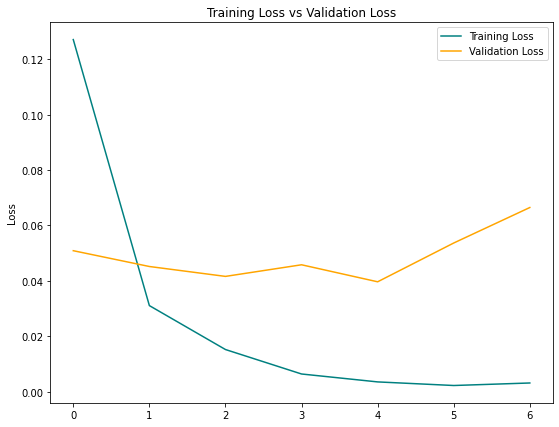

In [260]:
plt.figure(figsize=(9,7))
plt.plot(history.history['loss'],label='Training Loss',color='teal')
plt.plot(history.history['val_loss'],label='Validation Loss',color='orange')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [261]:
y_pred=model.predict(X_test)
y_pred[:10]

211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step


array([[2.8862376e-04],
       [9.9998516e-01],
       [5.5660901e-05],
       [9.9997783e-01],
       [9.9996787e-01],
       [5.5820263e-05],
       [6.5751614e-05],
       [7.1692506e-05],
       [9.9998611e-01],
       [1.6933582e-04]], dtype=float32)

In [263]:
y_predict=np.where(y_pred>0.5,1,0)

In [264]:
y_predict[:10]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [266]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3309
           1       0.98      0.99      0.99      3432

    accuracy                           0.99      6741
   macro avg       0.99      0.99      0.99      6741
weighted avg       0.99      0.99      0.99      6741



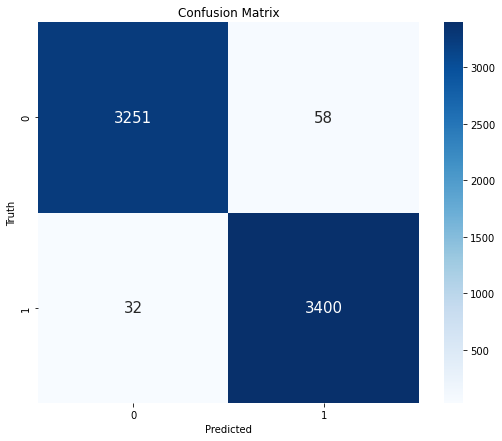

In [267]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()